In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [5]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from torchvision import datasets, transforms

In [6]:
# Prepare Dataset
# load data
train = pd.read_csv(r"/kaggle/input/digit-recognizer/train.csv",dtype = np.float32)

# split data into features(pixels) and labels(numbers from 0 to 9)
targets_numpy = train.label.values
features_numpy = train.loc[:,train.columns != "label"].values/255 # normalization

# train test split. Size of train data is 80% and size of test data is 20%. 
features_train, features_valid, targets_train, targets_valid = train_test_split(features_numpy,
                                                                             targets_numpy,
                                                                             test_size = 0.2,
                                                                             random_state = 42) 
# create feature and targets tensor for train set. As you remember we need variable to accumulate gradients. Therefore first we create tensor, then we will create variable
featuresTrain = torch.from_numpy(features_train)
targetsTrain = torch.from_numpy(targets_train).type(torch.LongTensor) # data type is long

# create feature and targets tensor for test set.
featuresValid = torch.from_numpy(features_valid)
targetsValid = torch.from_numpy(targets_valid).type(torch.LongTensor) # data type is long

# batch_size, epoch and iteration
batch_size = 100
n_iters = 10000
num_epochs = n_iters / (len(features_train) / batch_size)
num_epochs = int(num_epochs)

# Pytorch train and valid sets
train = torch.utils.data.TensorDataset(featuresTrain,targetsTrain)
valid = torch.utils.data.TensorDataset(featuresValid,targetsValid)


# data loader
train_loader = DataLoader(train, batch_size = batch_size, shuffle = False)
valid_loader = DataLoader(valid, batch_size = batch_size, shuffle = False)

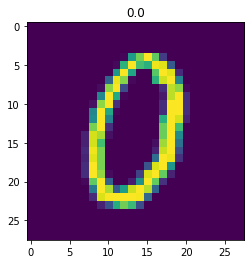

In [7]:
# visualize one of the images in data set
plt.imshow(features_numpy[5].reshape(28,28))
# plt.axis("off")
plt.title(str(targets_numpy[5]))
plt.savefig('graph.png')
plt.show()

In [8]:
# Create NN Model
class NNModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(NNModel, self).__init__()

        # 各クラスのインスタンス（入出力サイズなどの設定）
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, output_size)

    def forward(self, x):
        # 順伝播の設定（インスタンスしたクラスの特殊メソッド(__call__)を実行）
        x = self.fc1(x)
        x = torch.sigmoid(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
# ニューラルネットワークの生成
image_size = 28*28      # 画像の画素数(幅x高さ)
# GPU(CUDA)が使えるかどうか？
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 0.001   # 学習率

model = NNModel(image_size, 10).to(device)

# 損失関数の定義
criterion = nn.CrossEntropyLoss() 

# 最適化手法の設定
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) 

In [10]:
# 学習
model.train()  # モデルを訓練モードにする

for epoch in range(num_epochs): # 学習を繰り返し行う
    loss_sum = 0

    for inputs, labels in train_loader:

        # GPUが使えるならGPUにデータを送る
        inputs = inputs.to(device)
        labels = labels.to(device)

        # optimizerを初期化
        optimizer.zero_grad()

        # ニューラルネットワークの処理を行う
        inputs = inputs.view(-1, image_size) # 画像データ部分を一次元へ並び変える
        outputs = model(inputs)

        # 損失(出力とラベルとの誤差)の計算
        loss = criterion(outputs, labels)
        loss_sum += loss

        # 勾配の計算
        loss.backward()

        # 重みの更新
        optimizer.step()

    # 学習状況の表示
    print(f"Epoch: {epoch+1}/{num_epochs}, Loss: {loss_sum.item() / len(train_loader)}")

    # モデルの重みの保存
    torch.save(model.state_dict(), 'model_weights.pth')

Epoch: 1/29, Loss: 0.8998098827543712
Epoch: 2/29, Loss: 0.33875267846243723
Epoch: 3/29, Loss: 0.26408461162022184
Epoch: 4/29, Loss: 0.22520939509073892
Epoch: 5/29, Loss: 0.1974175771077474
Epoch: 6/29, Loss: 0.17555039269583567
Epoch: 7/29, Loss: 0.1576430911109561
Epoch: 8/29, Loss: 0.14260710988725936
Epoch: 9/29, Loss: 0.12974328086489723
Epoch: 10/29, Loss: 0.1185454527537028
Epoch: 11/29, Loss: 0.1086501848129999
Epoch: 12/29, Loss: 0.09981095223199754
Epoch: 13/29, Loss: 0.09185777959369477
Epoch: 14/29, Loss: 0.08466034843808129
Epoch: 15/29, Loss: 0.07810955955868676
Epoch: 16/29, Loss: 0.07211425190880186
Epoch: 17/29, Loss: 0.0666049321492513
Epoch: 18/29, Loss: 0.061527882303510396
Epoch: 19/29, Loss: 0.056837422507149835
Epoch: 20/29, Loss: 0.052493770917256675
Epoch: 21/29, Loss: 0.048462163834344776
Epoch: 22/29, Loss: 0.044713119665781655
Epoch: 23/29, Loss: 0.041222160770779566
Epoch: 24/29, Loss: 0.03796885978607904
Epoch: 25/29, Loss: 0.03493611869357881
Epoch: 26

In [11]:
#----------------------------------------------------------
# 評価
model.eval()  # モデルを評価モードにする

loss_sum = 0
correct = 0

with torch.no_grad():
    for inputs, labels in valid_loader:

        # GPUが使えるならGPUにデータを送る
        inputs = inputs.to(device)
        labels = labels.to(device)

        # ニューラルネットワークの処理を行う
        inputs = inputs.view(-1, image_size) # 画像データ部分を一次元へ並び変える
        outputs = model(inputs)

        # 損失(出力とラベルとの誤差)の計算
        loss_sum += criterion(outputs, labels)

        # 正解の値を取得
        pred = outputs.argmax(1)
        # 正解数をカウント
        correct += pred.eq(labels.view_as(pred)).sum().item()

print(f"Loss: {loss_sum.item() / len(valid_loader)}, Accuracy: {100*correct/len(valid)}% ({correct}/{len(valid)})")

Loss: 0.10310974575224377, Accuracy: 96.8452380952381% (8135/8400)


In [12]:
test = pd.read_csv(r"/kaggle/input/digit-recognizer/test.csv",dtype = np.float32)
test_targets_numpy = test.loc[:,test.columns != "label"].values/255 # normalization
targetsTest = torch.from_numpy(test_targets_numpy)
test = torch.utils.data.TensorDataset(targetsTest)
test_loader =  DataLoader(test, shuffle = False)

In [13]:
pred = []
cnt = 0
for x in test_loader:
    with torch.no_grad():
        output = model(x[0])
    pred += [int(l.argmax()) for l in output]
    cnt += 1

In [14]:
submission = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
submission['Label'] = pred
submission.to_csv('submission.csv', index=False)
submission.head(20)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3
